#### 作业2 语音识别实现


In [62]:
import numpy as np
import sklearn.model_selection as sm
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader 

tr_path = './timit_11/train_11.npy'
tr_label_path = './timit_11/train_label_11.npy'

data = np.load(tr_path)
label = np.load(tr_label_path)
print(data.shape, label.shape)            

split_index = np.arange(0,data.shape[0])
train_index, valid_index = sm.train_test_split(split_index,test_size=0.2)
print('分割索引结束!')
train_data = data[train_index]
print('分割 train_data 结束!')
train_label = label[train_index]
print('分割 train_label 结束!')
valid_data = data[valid_index]
valid_label = label[valid_index]

# VAL_RATIO = 0.2  # val_ratto 默认是0.2， 如果为0的话是拿所有数据进行训练。
# percent = int(data.shape[0] * (1 - VAL_RATIO))
# train_data,train_label,valid_data, valid_label = data[:percent], label[:percent], data[percent:], label[percent:]
# dim = train_data[1].shape
# print(dim)

(1229932, 429) (1229932,)
分割索引结束!
分割 train_data 结束!
分割 train_label 结束!


#### create dataSet

In [63]:
class TIMITDataSet(Dataset):
    def __init__(self, train_data,train_label, valid_data, valid_label, model):
        
        if model == 'train':
            print('train size: {}'.format(train_data.shape))
            self.dim = train_data[1].shape
            self.data = torch.from_numpy(train_data).float()
            train_label = train_label.astype(np.int)
            self.label = torch.LongTensor(train_label)

        elif model == 'valid':
            print('valid size: {}'.format(valid_data.shape))
            self.dim = valid_data.shape[1]
            self.data = torch.from_numpy(valid_data).float()
            valid_label = valid_label.astype(np.int)
            self.label = torch.LongTensor(valid_label)
        else:
            print('未知模型参数: {}、无法加载数据'.format(model))
    
    def __getitem__(self, index):
        if self.label is None:
            return self.data[index]
        else:
            return self.data[index], self.label[index]
            
    def __len__(self):
            return len(self.data)        


#### 判断是否支持GPU

In [64]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else  'cpu'

#### 加载数据

In [65]:
# train_set = TIMITDataSet(tr_path, 'train',tr_label_path)
# valid_set = TIMITDataSet(tr_path, 'valid',tr_label_path)
# train_loader = DataLoader(train_set,batch_size=80)

#### 清理内存
** 后续使用的内存比较大、这里清一下内存 **

In [66]:
# import gc

# del train_data, train_label, valid_data, valid_label

# gc.collect()

In [67]:
#### 创建模型

In [68]:
class TIMITModelNet(nn.Module):
    def __init__(self):
        super(TIMITModelNet, self).__init__()
        # self.net = nn.Sequential(
        #     nn.Linear(429, 1024),
        #     nn.Sigmoid(),
        #     nn.Linear(1024,512),
        #     nn.Sigmoid(),
        #     nn.Linear(512,256),
        #     nn.Sigmoid(),
        #     nn.Linear(256, 39),
        #     nn.Sigmoid()
        # )
        self.net = nn.Sequential(
        nn.Linear(429, 812),
        nn.Sigmoid(),
        nn.Linear(812,256),
        nn.Sigmoid(),
        nn.Linear(256, 39),
        nn.Sigmoid()
        )
        self.mes_loss = nn.CrossEntropyLoss()
    def forward(self,x):
        return self.net(x)
        
    def loss_criterion(self,pred, target):
        # print('预测值: ', pred.size())
        # print('实际值:', target.size())
        return self.mes_loss(pred, target)

#### 验证模型

In [69]:
def validModel(model,valid_set,device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x,y in valid_set:
            x , y = x.to(device), y.to(device)
            valid_y = model(x)
            mse_loss = model.loss_criterion(valid_y,y)
            total_loss +=mse_loss
    return total_loss / len(valid_set)

#### 开始训练模型

In [70]:
def TrainModel(train_set,valid_set, model, epochs,device, save_path):
    loss_record = {'train':[],'valid':[]}
    optm = torch.optim.SGD(model.parameters(),lr=0.0005)
    epoch = 1
    min_loss = 100000
    while epoch < epochs:
        print('进入训练')
        model.train()
        for x, y in train_set:
            # print('x值: {}, y值:{}'.format(x,y))
            optm.zero_grad()
            x,y = x.to(device), y.to(device)
            pred_y = model(x)
            MSE_loss =  model.loss_criterion(pred_y,y)
            MSE_loss.backward()
            optm.step()
            loss_record['train'].append(MSE_loss.detach().cpu().numpy())
            valid_loss = validModel(model,valid_set,device)
            loss_record['valid'].append(valid_loss.detach().cpu().numpy())
            if min_loss > valid_loss:
                min_loss = valid_loss
                torch.save(model.state_dict(), save_path)
                print('epoch:{},loss:{},loss降低,保存模型、'.format(epoch+1,min_loss))
            else:
                print('epoch:{},model loss:{}, valid loass'.format(epoch+1,min_loss, valid_loss))
            epoch +=1
            print('模型训练中、epoch:{},MSE_loss:{}'.format(epoch,MSE_loss))
            if epoch %100 ==0:
                torch.save(model.state_dict(), save_path)
                print('epoch:{},loss:{},loss降低,保存模型、'.format(epoch+1,min_loss))

    print('完成模型训练、epoch:{},loss:{}'.format(epoch+1,MSE_loss))
    return loss_record

#### 开始训练

In [71]:
save_path = './model/model.hw2'
valid_set = DataLoader(TIMITDataSet(train_data,train_label,valid_data,valid_label,'valid'),batch_size=32,shuffle=False)
train_set = DataLoader(TIMITDataSet(train_data,train_label,valid_data,valid_label,'train'),batch_size=32,shuffle=True)
print('load data success!')
model = TIMITModelNet()
print('load model success')
loss_record = TrainModel(train_set,valid_set,model,1000,get_device(),save_path)

valid size: (245987, 429)
train size: (983945, 429)
load data success!
load model success
进入训练
epoch:2,loss:3.6555335521698,loss降低,保存模型、
模型训练中、epoch:2,MSE_loss:3.6582589149475098
epoch:3,loss:3.655494213104248,loss降低,保存模型、
模型训练中、epoch:3,MSE_loss:3.6419880390167236
epoch:4,loss:3.6554434299468994,loss降低,保存模型、
模型训练中、epoch:4,MSE_loss:3.655946969985962
epoch:5,loss:3.655381441116333,loss降低,保存模型、
模型训练中、epoch:5,MSE_loss:3.6409449577331543
epoch:6,loss:3.655346393585205,loss降低,保存模型、
模型训练中、epoch:6,MSE_loss:3.660783052444458
epoch:7,loss:3.6553144454956055,loss降低,保存模型、
模型训练中、epoch:7,MSE_loss:3.6357479095458984
epoch:8,loss:3.6552634239196777,loss降低,保存模型、
模型训练中、epoch:8,MSE_loss:3.6610212326049805
epoch:9,loss:3.6552090644836426,loss降低,保存模型、
模型训练中、epoch:9,MSE_loss:3.650763511657715
epoch:10,loss:3.6551599502563477,loss降低,保存模型、
模型训练中、epoch:10,MSE_loss:3.6331520080566406
epoch:11,loss:3.6551082134246826,loss降低,保存模型、
模型训练中、epoch:11,MSE_loss:3.6525814533233643
epoch:12,loss:3.6550443172454834,loss降低,

KeyboardInterrupt: 

#### 绘制损失函数曲线

In [ ]:
def plot_learn_curve(loss_record):
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['train'])]
    plt.figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    # plt.plot(x_2, loss_record['valid'], c='tab:cyan', label='valid')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of train')
    plt.legend()
    plt.show()

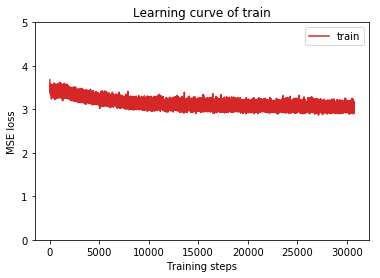

In [ ]:
plot_learn_curve(loss_record)

#### 绘制验证值曲线

ValueError: x and y must be the same size

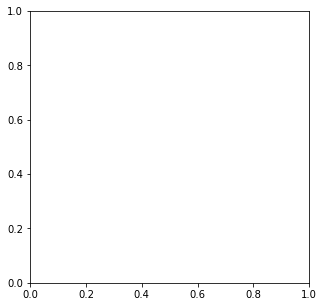

In [ ]:
def plot_pred(valid_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in valid_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    plt.figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

#开始绘制
plot_pred(valid_set,model,get_device())